In [1]:

# Set up notebook
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# load libraries
from FRVRS import fu, nu
from datetime import date, timedelta
from pandas import DataFrame, to_datetime, Series
import numpy as np
import os
import os.path as osp
from IPython.display import HTML
import pandas as pd

In [3]:

# load data frames
data_frames_list = nu.load_data_frames(
    verbose=False, metrics_evaluation_open_world_df='', metrics_evaluation_open_world_file_stats_df='', metrics_evaluation_open_world_scene_stats_df=''
)
logs_df = data_frames_list['metrics_evaluation_open_world_df']
print(logs_df.shape)
file_stats_df = data_frames_list['metrics_evaluation_open_world_file_stats_df']
print(file_stats_df.shape)
scene_stats_df = data_frames_list['metrics_evaluation_open_world_scene_stats_df']
print(scene_stats_df.shape)

(276926, 107)
(86, 3971)
(133, 48)


In [4]:

needed_columns = [
    'scene_type', 'is_scene_aborted', 'is_a_one_triage_file', 'responder_category', 'responder_type', 'configData_scene',
    'configData_scenarioData_name', 'configData_scenarioData_description', 'encounter_layout'
]
elevens_df = fu.get_elevens_data_frame(
    logs_df, file_stats_df, scene_stats_df, needed_columns=needed_columns, patient_count_filter_fn=lambda x: x.patient_id.nunique() >= 1
)
print(elevens_df.shape)

(147298, 115)


In [5]:

# Test all the methods used in this notebook in one test suite
import unittest
if ('../tests' not in sys.path): sys.path.insert(1, '../tests')
suite = unittest.TestSuite()

# Add all test cases from each class to the suite
from test_frvrs_utils_patient_functions import (
    TestGetPatientLocation
)
suite.addTest(unittest.makeSuite(TestGetPatientLocation))

# Run the test suite
runner = unittest.TextTestRunner()
runner.run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 0.007s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>


<h2>Here is my initial list but I am open to suggestions and modifications</h2>
<h3>IVs (these are not available in the csv; we are working on calculating them now and can get you that info.)</h3>
<ul>
    <li>Participant medical role</li>
    <li>Years of experience</li>
    <li>ST alignment score (continuous or group assignment)</li>
    <li>AD alignment score (continuous or group assignment)</li>
</ul>
<h3>DVs</h3>
<ul>
    <li>Total number of actions</li>
    <li>Count of assessment actions</li>
    <li>Count of treatment actions</li>
    <li>Count of tags applied</li>
    <li>Order of patients engaged</li>
    <li>Tag color for each patient</li>
    <li>Treat expectant patient (yes/no)</li>
    <li>Triage efficiency</li>
    <li>Time to hemorrhage control</li>
</ul>

In [47]:

# Get all patient stats
from numpy import nan

rows_list = []
for (encounter_layout, session_uuid, scene_id, patient_id), patient_df in elevens_df.groupby(['encounter_layout'] + fu.patient_groupby_columns):
    row_dict = {cn: eval(cn) for cn in ['encounter_layout'] + fu.patient_groupby_columns}
    
    row_dict['correct_bleeding_tool_applied'] = fu.get_is_correct_bleeding_tool_applied(patient_df)
    row_dict['first_patient_interaction'] = fu.get_first_patient_interaction(patient_df)
    row_dict['last_patient_interaction'] = fu.get_last_patient_interaction(patient_df)
    row_dict['last_tag'] = fu.get_last_tag(patient_df)
    row_dict['life_threatened'] = fu.get_is_life_threatened(patient_df)
    row_dict['max_salt'] = fu.get_max_salt(patient_df)
    row_dict['maximum_injury_severity'] = fu.get_maximum_injury_severity(patient_df)
    row_dict['patient_dead'] = fu.get_is_patient_dead(patient_df)
    row_dict['patient_engagement_count'] = fu.get_patient_engagement_count(patient_df)
    row_dict['patient_gazed_at'] = fu.get_is_patient_gazed_at(patient_df)
    row_dict['patient_hemorrhaging'] = fu.get_is_patient_hemorrhaging(patient_df)
    row_dict['patient_severely_hemorrhaging'] = fu.get_is_patient_severely_hemorrhaging(patient_df)
    row_dict['patient_still'] = fu.get_is_patient_still(patient_df)
    row_dict['pulse_value'] = fu.get_pulse_value(patient_df)
    row_dict['tag_value'] = fu.get_tag_value(patient_df)
    row_dict['time_to_hemorrhage_control'] = fu.get_time_to_hemorrhage_control(patient_df)
    
    mask_series = ~patient_df.tag_applied_type.isnull()
    tag_applied_type_count = patient_df[mask_series].tag_applied_type.unique().shape[0]
    mask_series = ~patient_df.patient_record_salt.isnull()
    patient_record_salt_count = patient_df[mask_series].patient_record_salt.unique().shape[0]
    if (tag_applied_type_count > 0) and (patient_record_salt_count > 0): row_dict['tag_correct'] = fu.get_is_tag_correct(patient_df)
    else: row_dict['tag_correct'] = nan
    
    mask_series = patient_df.action_type.isin(fu.action_types_list)
    row_dict['action_count'] = patient_df[mask_series].shape[0]
    
    mask_series = patient_df.action_type.isin(['PATIENT_ENGAGED', 'PULSE_TAKEN'])
    row_dict['assessment_count'] = patient_df[mask_series].shape[0]
    
    mask_series = patient_df.action_type.isin(['INJURY_TREATED'])
    row_dict['treatment_count'] = patient_df[mask_series].shape[0]
    
    mask_series = patient_df.action_type.isin(['TAG_APPLIED'])
    row_dict['tag_application_count'] = patient_df[mask_series].shape[0]
    
    if (row_dict['max_salt'] == 'EXPECTANT'):
        mask_series = ~patient_df.injury_treated_required_procedure.isnull() | ~patient_df.tool_applied_type.isnull()
        row_dict['treated_expectant'] = {True: 'yes', False: 'no'}[mask_series.any()]
    else: row_dict['treated_expectant'] = nan
    
    rows_list.append(row_dict)
patient_stats_df = DataFrame(rows_list)
patient_stats_df.max_salt = patient_stats_df.max_salt.astype(fu.salt_category_order)
patient_stats_df.last_tag = patient_stats_df.last_tag.astype(fu.colors_category_order)
df = nu.get_column_descriptions(patient_stats_df)
# mask_series = (df.min_value == False) & (df.max_value == True) & (df.dtype == 'object')
# for cn in df[mask_series].column_name: patient_stats_df[cn] = patient_stats_df[cn].astype(bool)
print(patient_stats_df.shape)

(593, 26)


In [54]:

# display(df)
mask_series = (df.dtype == 'int64')
print()
for cn in df[mask_series].column_name:
    print(f"""            row_dict['max_{cn}'] = scene_df.{cn}.max()""")


            row_dict['max_scene_id'] = scene_df.scene_id.max()
            row_dict['max_patient_engagement_count'] = scene_df.patient_engagement_count.max()
            row_dict['max_pulse_value'] = scene_df.pulse_value.max()
            row_dict['max_tag_value'] = scene_df.tag_value.max()
            row_dict['max_time_to_hemorrhage_control'] = scene_df.time_to_hemorrhage_control.max()
            row_dict['max_action_count'] = scene_df.action_count.max()
            row_dict['max_assessment_count'] = scene_df.assessment_count.max()
            row_dict['max_treatment_count'] = scene_df.treatment_count.max()
            row_dict['max_tag_application_count'] = scene_df.tag_application_count.max()


In [56]:

desert_patients_list = ['Open World Marine 1 Female Root', 'Open World Marine 2 Male Root', 'Open World Civilian 1 Male Root', 'Open World Civilian 2 Female Root']
jungle_patients_list = ['Open World Marine 1 Male Root', 'Open World Marine 2 Female Root', 'Open World Marine 3 Male Root', 'Open World Marine 4 Male Root']
submarine_patients_list = ['Navy Soldier 1 Male Root', 'Navy Soldier 2 Male Root', 'Navy Soldier 3 Male Root', 'Navy Soldier 4 Female Root']
urban_patients_list = ['Marine 1 Male Root', 'Marine 2 Male Root', 'Marine 3 Male Root', 'Marine 4 Male Root', 'Civilian 1 Female Root']
rows_list = []
for encounter_layout, encounter_layout_df in patient_stats_df.groupby('encounter_layout'):
    patients_list = eval(f'{encounter_layout.lower()}_patients_list')
    for (session_uuid, scene_id), scene_df in encounter_layout_df.groupby(fu.scene_groupby_columns):
        mask_series = scene_df.patient_id.isin(patients_list)
        if mask_series.any():
            row_dict = {'Environment': encounter_layout, 'session_uuid': session_uuid, 'scene_id': scene_id}

            # Get the start of the whole scene
            scene_mask_series = True
            for cn in fu.scene_groupby_columns: scene_mask_series &= (elevens_df[cn] == eval(cn))
            scene_start = fu.get_scene_start(elevens_df[scene_mask_series])
            
            row_dict['mean_first_patient_interaction'] = scene_df.first_patient_interaction.map(lambda x: x - scene_start).mean()
            row_dict['mean_last_patient_interaction'] = scene_df.last_patient_interaction.map(lambda x: x - scene_start).mean()
            row_dict['total_patient_engagement_count'] = scene_df.patient_engagement_count.sum()
            row_dict['total_action_count'] = scene_df.action_count.sum()
            row_dict['total_assessment_count'] = scene_df.assessment_count.sum()
            row_dict['total_treatment_count'] = scene_df.treatment_count.sum()
            row_dict['total_tag_application_count'] = scene_df.tag_application_count.sum()
            row_dict['max_time_to_hemorrhage_control'] = scene_df.time_to_hemorrhage_control.max() - scene_start

            mask_series = (scene_df.treated_expectant == 'yes')
            row_dict['treated_expectant'] = mask_series.any()

            # Get the whole scene history
            scene_df = elevens_df[scene_mask_series]
            mask_series = scene_df.patient_id.isin(patients_list)
            
            row_dict['TtTS'] = fu.get_triage_time(scene_df[mask_series])
            row_dict['TtHC'] = fu.get_time_to_last_hemorrhage_controlled(scene_df[mask_series])
            times_list = []
            for patient_id, patient_df in scene_df[mask_series].groupby('patient_id'):
                if fu.get_is_patient_hemorrhaging(patient_df):
                    controlled_time = fu.get_time_to_hemorrhage_control(patient_df, scene_start=None)
                    times_list.append(controlled_time)
            row_dict['MTfHCpP'] = Series(times_list).mean()
            mask_series = (correct_count_by_tag_df.session_uuid == session_uuid) & (correct_count_by_tag_df.scene_id == scene_id)
            if mask_series.any():
                row_dict['MPAT'] = correct_count_by_tag_df[mask_series].percentage_tag_correct.mean()
            
            rows_list.append(row_dict)
anova_df = DataFrame(rows_list)

NameError: name 'correct_count_by_tag_df' is not defined

In [46]:

# mask_series = patient_stats_df.patient_id.isin(desert_patients_list + jungle_patients_list + submarine_patients_list + urban_patients_list)
mask_series = ~patient_stats_df.treated_expectant.isnull()
# mask_series &= (patient_stats_df.max_salt == 'EXPECTANT')
columns_list = [
    'correct_bleeding_tool_applied', 'first_patient_interaction', 'last_patient_interaction', 'last_tag', 'life_threatened', 'max_salt',
    'maximum_injury_severity', 'patient_dead', 'patient_engagement_count', 'patient_gazed_at', 'patient_hemorrhaging',
    'patient_severely_hemorrhaging', 'patient_still', 'pulse_value', 'tag_correct', 'tag_value', 'time_to_hemorrhage_control',
    'action_count', 'assessment_count', 'treatment_count', 'tag_application_count', 'treated_expectant', 'encounter_layout'
]
if mask_series.any():
    df = patient_stats_df[mask_series][columns_list]
    display(df.sample(min(10, df.shape[0])).dropna(axis='columns', how='all').T)

,16,382,468,103,399,29,589,415,132,575
correct_bleeding_tool_applied,False,False,False,False,False,False,False,False,False,False
first_patient_interaction,NaN,NaN,567282.0,582546.0,NaN,NaN,NaN,NaN,NaN,498061.0
last_patient_interaction,NaN,NaN,614802.0,591563.0,NaN,NaN,NaN,NaN,NaN,868355.0
last_tag,NaN,NaN,gray,NaN,NaN,NaN,NaN,NaN,NaN,gray
life_threatened,False,True,True,True,True,True,True,True,False,True
max_salt,EXPECTANT,EXPECTANT,EXPECTANT,EXPECTANT,EXPECTANT,EXPECTANT,EXPECTANT,EXPECTANT,EXPECTANT,EXPECTANT
maximum_injury_severity,NaN,high,high,high,high,high,high,high,medium,high
patient_dead,True,True,True,True,True,True,True,True,True,True
patient_engagement_count,0,0,1,3,0,0,0,0,0,2
patient_gazed_at,False,False,False,False,False,False,False,False,True,True


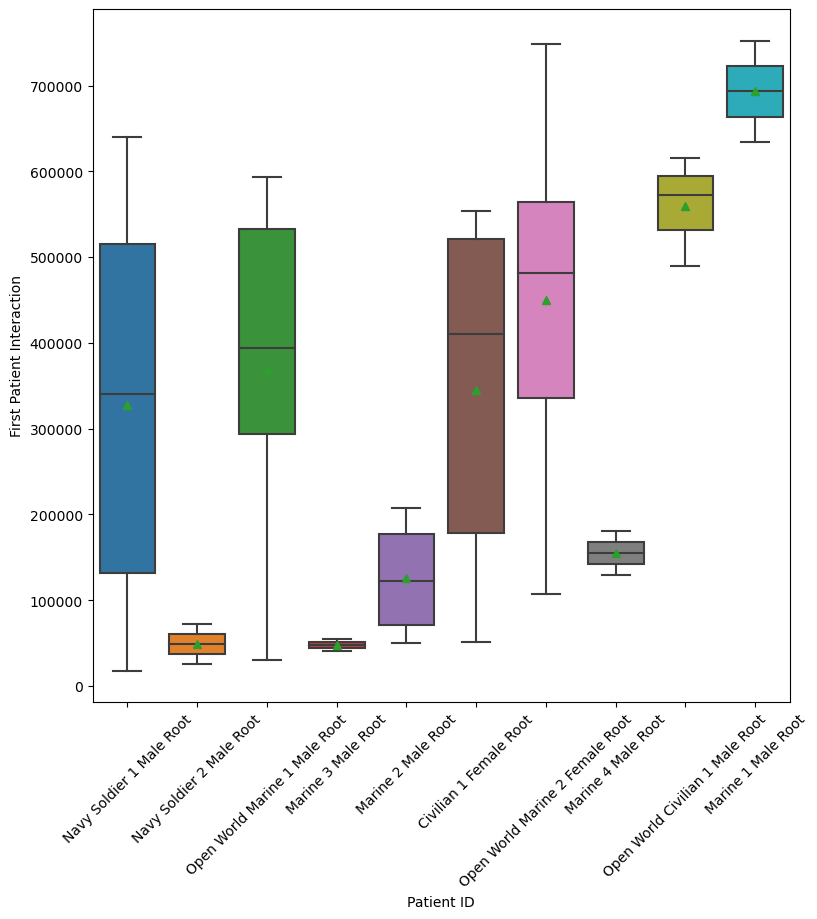

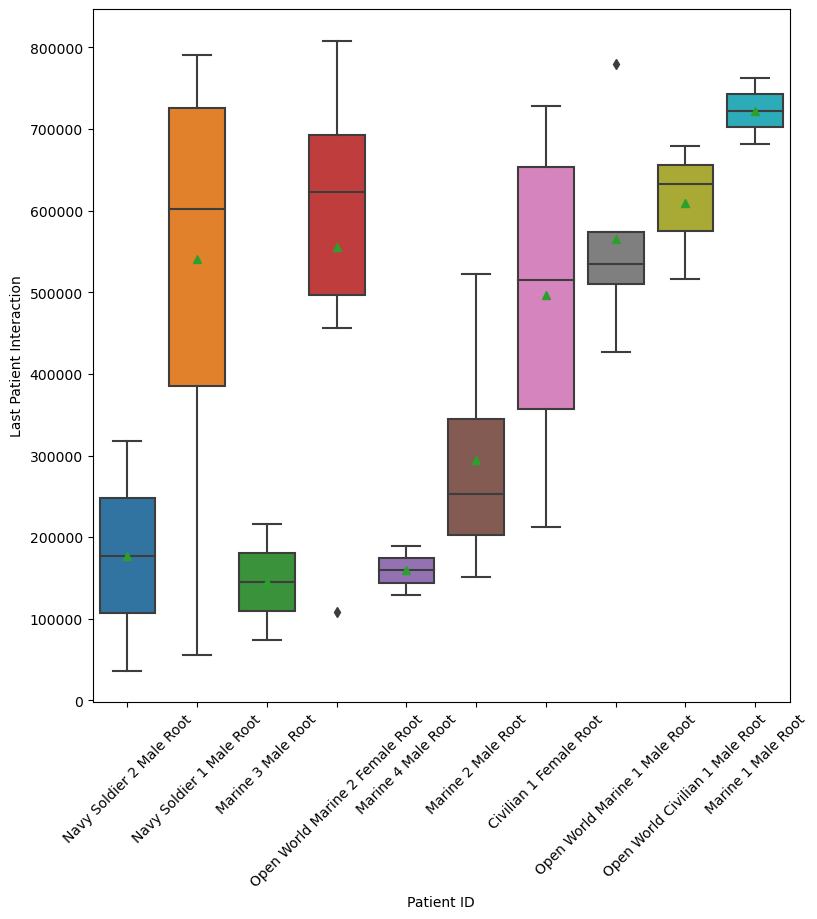

In [7]:

desert_patients_list = ['Open World Marine 1 Female Root', 'Open World Marine 2 Male Root', 'Open World Civilian 1 Male Root', 'Open World Civilian 2 Female Root']
jungle_patients_list = ['Open World Marine 1 Male Root', 'Open World Marine 2 Female Root', 'Open World Marine 3 Male Root', 'Open World Marine 4 Male Root']
submarine_patients_list = ['Navy Soldier 1 Male Root', 'Navy Soldier 2 Male Root', 'Navy Soldier 3 Male Root', 'Navy Soldier 4 Female Root']
urban_patients_list = ['Marine 1 Male Root', 'Marine 2 Male Root', 'Marine 3 Male Root', 'Marine 4 Male Root', 'Civilian 1 Female Root']
for cn in ['first_patient_interaction', 'last_patient_interaction']:
    mask_series = patient_stats_df.patient_id.isin(desert_patients_list + jungle_patients_list + submarine_patients_list + urban_patients_list)
    mask_series &= ~patient_stats_df[cn].isnull()
    if mask_series.any():
        transformable_df = patient_stats_df[mask_series].groupby(fu.scene_groupby_columns).min().reset_index(drop=False).sort_values(cn)
        fu.plot_grouped_box_and_whiskers(
            transformable_df,
            'patient_id',
            cn,
            'Patient ID',
            ' '.join([w.title() for w in cn.split('_')]),
            transformer_name=None,
            is_y_temporal=False,
        )

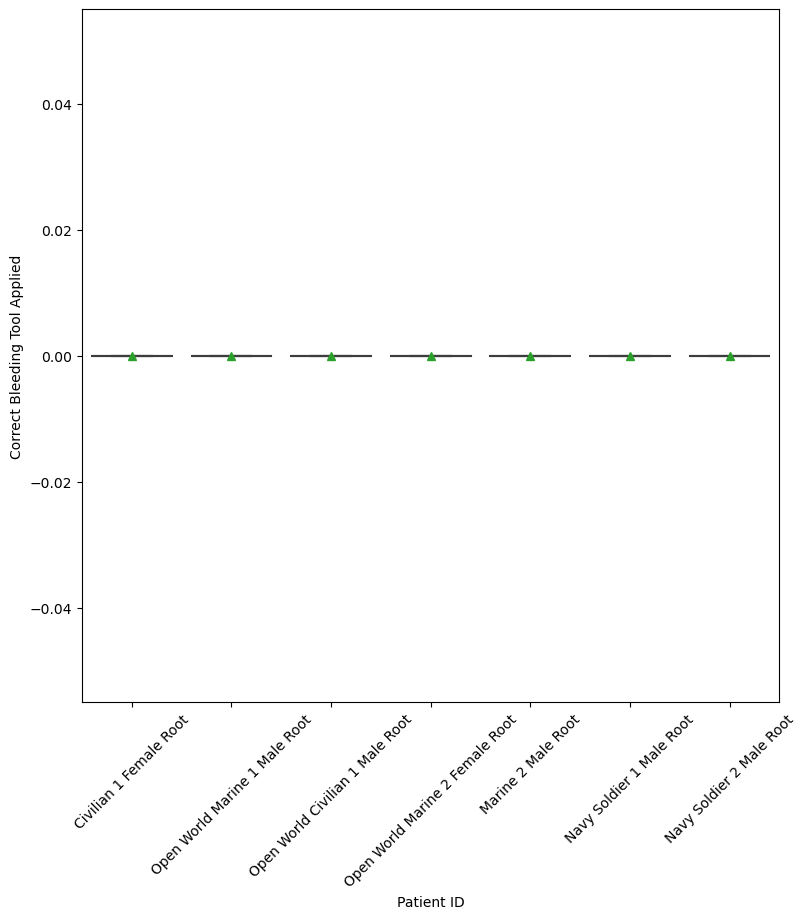

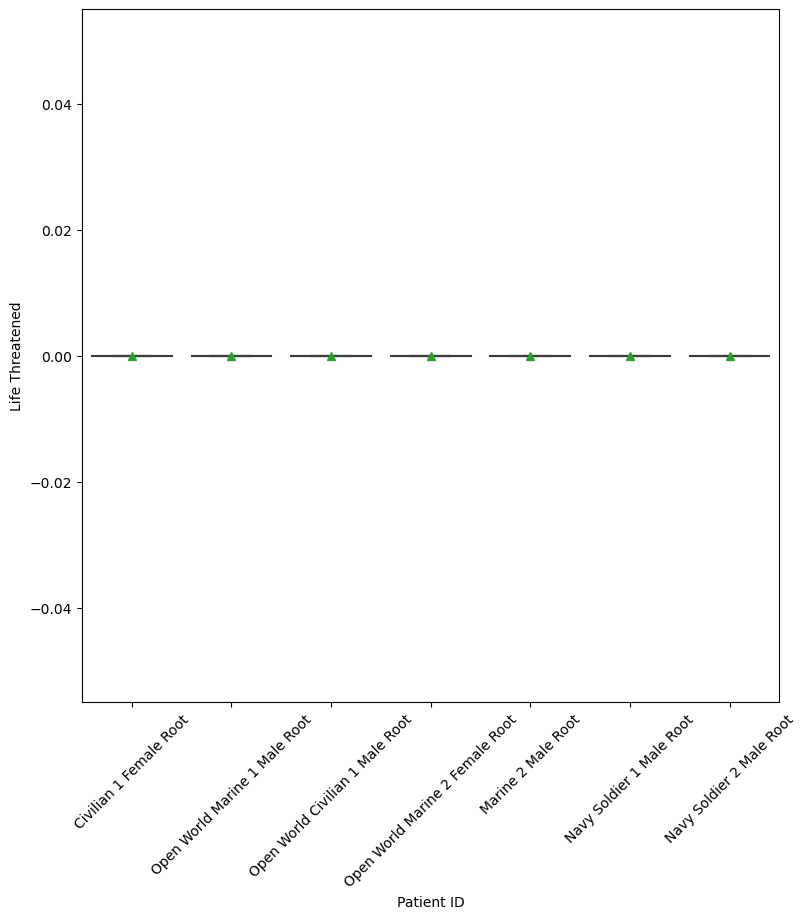

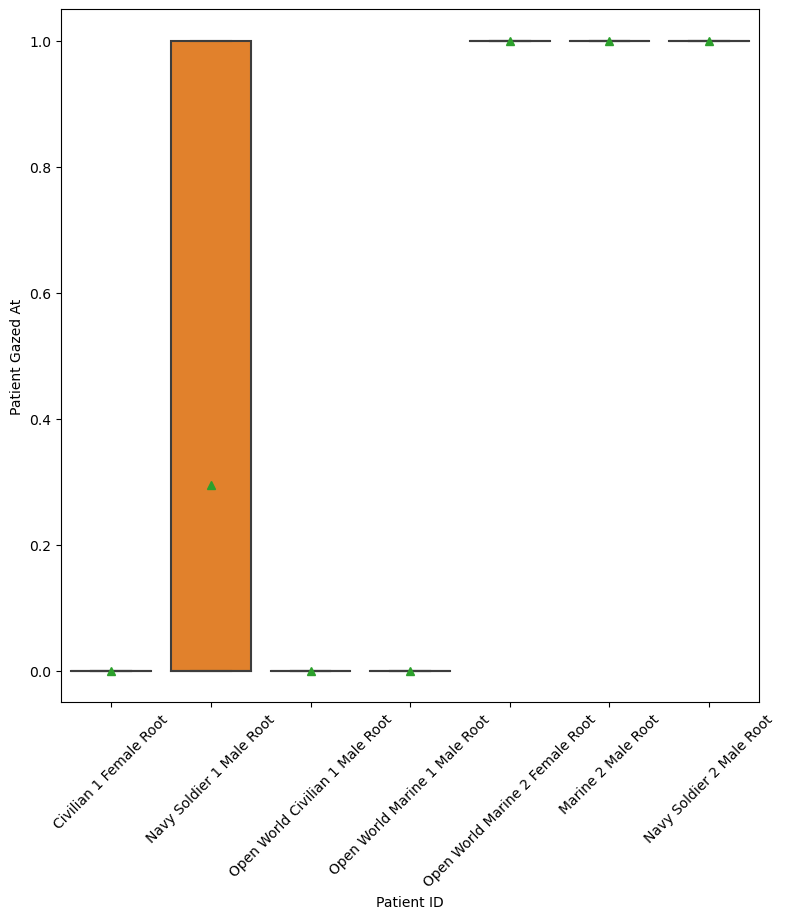

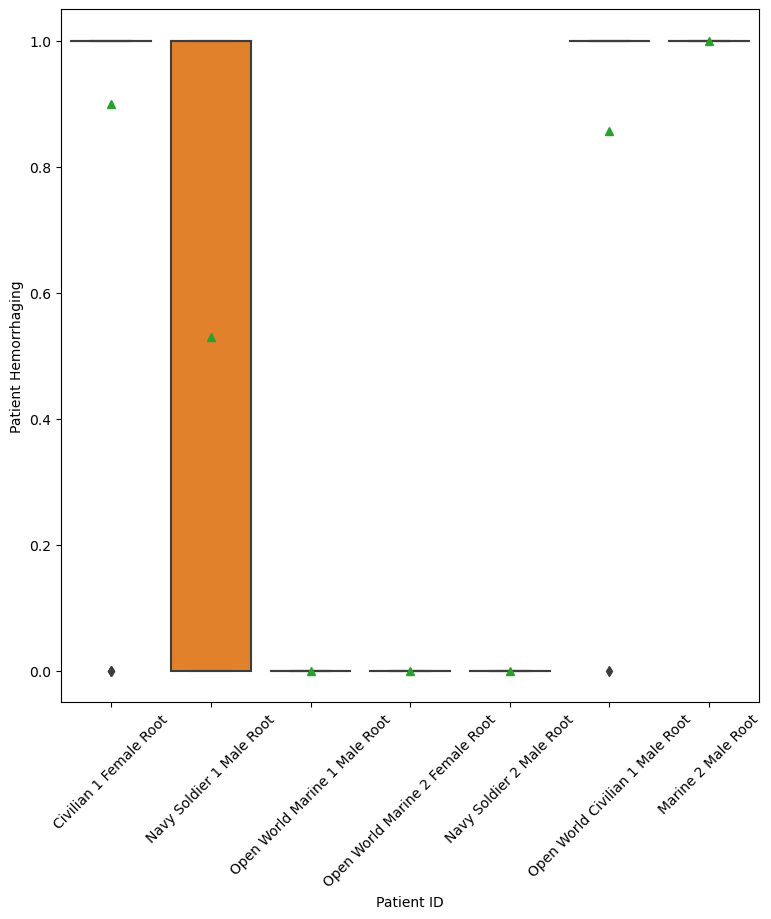

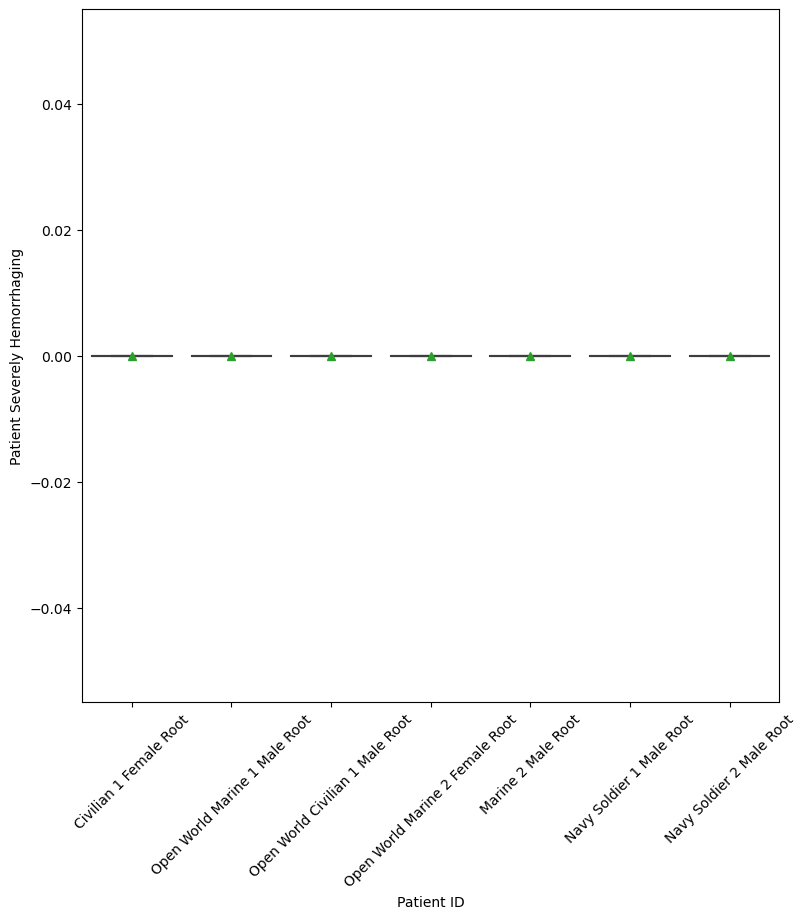

In [9]:

df = nu.get_column_descriptions(patient_stats_df)
mask_series = (df.dtype == 'bool')
for cn in df[mask_series].column_name:
    mask_series = patient_stats_df.patient_id.isin(desert_patients_list + jungle_patients_list + submarine_patients_list + urban_patients_list)
    mask_series &= ~patient_stats_df[cn].isnull()
    if mask_series.any():
        transformable_df = patient_stats_df[mask_series].groupby(fu.scene_groupby_columns).min().reset_index(drop=False).sort_values(cn)
        transformable_df[cn] = transformable_df[cn].map(lambda x: int(x))
        fu.plot_grouped_box_and_whiskers(
            transformable_df,
            'patient_id',
            cn,
            'Patient ID',
            ' '.join([w.title() for w in cn.split('_')]),
            transformer_name=None,
            is_y_temporal=False,
        )